In [1]:
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib notebook
sns.set()

# Market rate for carrots and potatoes

<IPython.core.display.Javascript object>


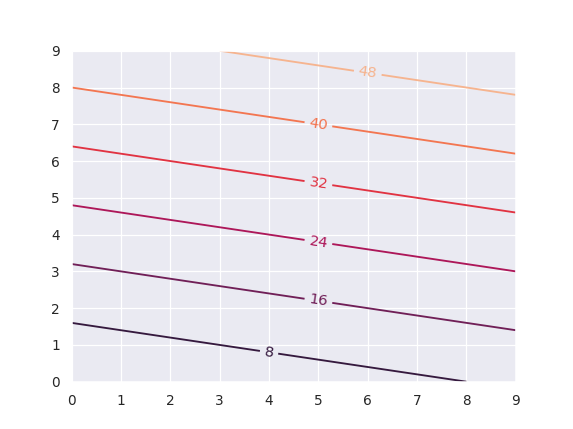

interactive(children=(FloatSlider(value=5.0, description='ratio', max=10.0), Output()), _dom_classes=('widget-…

<function __main__.plot_market_landscape(ratio)>

In [10]:
fig = plt.figure()

def price(ratio, potato, carrot):
    potato_price = 1  # €/potato
    carrot_price = potato_price*ratio
    return potato*potato_price + carrot*carrot_price

def plot_market_landscape(ratio):
    plt.clf()
    X,Y = np.meshgrid(np.arange(0, 10), np.arange(0, 10))
    Z = price(ratio, X, Y)
    cs = plt.contour(X, Y, Z)
    plt.clabel(cs)
    fig.show()


widgets.interact(plot_market_landscape, ratio=(0.,10.))

<IPython.core.display.Javascript object>


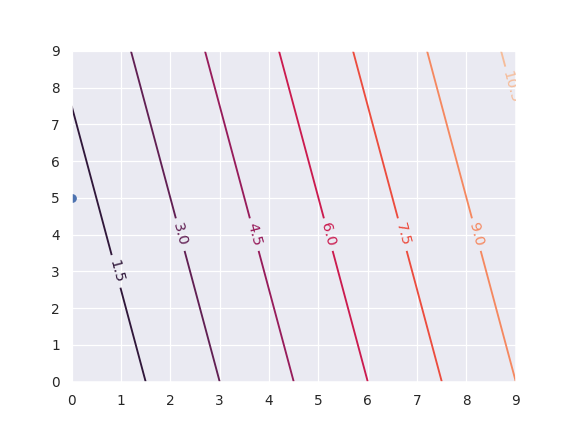

interactive(children=(FloatSlider(value=5.0, description='ratio', max=10.0), FloatSlider(value=1.5, descriptio…

<function __main__.alice(ratio, potato, carrot)>

In [11]:
fig = plt.figure()

def alice(ratio, potato, carrot):
    plot_market_landscape(ratio)
    if potato/3. + carrot/5. <= 1:
        plt.scatter(potato, carrot)
        return price(ratio, potato, carrot)
    return "Alice can't produce that much"

widgets.interact(alice, ratio=(0.,10.), potato=(0., 3.), carrot=(0., 5.))